In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
df_task = pd.read_csv("Data/Parker/parker new nback 1_27.11.20_18.01.15.md.bp.csv", skiprows=1)
df_control = pd.read_csv("Data/Parker/parker control 2_25.11.20_19.19.36.md.pm.bp.csv", skiprows=1)
df_task.dropna(subset=["POW.AF4.Alpha"], inplace=True)
df_control.dropna(subset=["POW.AF4.Alpha"], inplace=True)

In [3]:
df_task.head()

,Timestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,...,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma
12,1.606522e+09,118.0,0.0,4224.358887,4229.487305,4238.974121,4330.897461,4571.282227,4219.743652,4238.333496,...,13.917477,4.983940,2.082821,1.696961,2.023704,13.223186,4.987593,1.908210,1.068960,1.465190
28,1.606522e+09,6.0,0.0,4118.205078,4243.589844,4150.897461,4611.153809,4652.692383,4141.794922,4163.717773,...,16.544249,5.049778,1.720889,1.586476,1.939206,15.908467,4.970603,1.610681,1.014201,1.342458
44,1.606522e+09,22.0,0.0,4194.358887,4466.025879,4236.666504,5103.974121,4588.974121,4204.230957,4202.307617,...,17.855951,4.932714,1.377545,1.501595,1.720720,17.724880,4.692784,1.295692,0.964463,1.168935
60,1.606522e+09,38.0,0.0,4241.025879,4592.436035,4284.230957,5118.077148,4567.051270,4256.282227,4253.205078,...,18.025751,4.876716,1.115399,1.434085,1.416041,18.545540,4.201665,1.048362,0.917509,0.966057
76,1.606522e+09,54.0,0.0,4198.461426,4523.717773,4233.461426,5019.743652,4391.025879,4222.436035,4220.128418,...,18.914663,5.332583,0.961692,1.388154,1.104800,18.921238,3.716677,0.923073,0.868960,0.770817


In [4]:
df_task = df_task.filter(regex="Timestamp|EEG.AF|EEG.F|BetaL")
df_task = df_task.filter(regex="Timestamp|EEG.AF|EEG.F|POW.F|POW.AF")
# df_task['Timestamp'] = df_task['Timestamp']-df_task['Timestamp'].iloc[0]
df_task.set_index("Timestamp", inplace=True)
df_task["Label"] = 1

df_control = df_control.filter(regex="Timestamp|EEG.AF|EEG.F|BetaL")
df_control = df_control.filter(regex="Timestamp|EEG.AF|EEG.F|POW.F|POW.AF")
# df_control['Timestamp'] = df_control['Timestamp']-df_control['Timestamp'].iloc[0]
df_control.set_index("Timestamp", inplace=True)
df_control["Label"] = 0

In [5]:
# WARNING: NOT NORMALIZED!!!!!

df_all = pd.concat([df_task, df_control])
df_all = df_all.sample(frac=1.0)

X_train = np.array(df_all.iloc[:int(0.7*len(df_all)), :-1])
Y_train = np.array(df_all.iloc[:int(0.7*len(df_all)), -1:])

X_val = np.array(df_all.iloc[int(0.7*len(df_all)):, :-1])
Y_val = np.array(df_all.iloc[int(0.7*len(df_all)):, -1:])

df_all.head()

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4,POW.AF3.BetaL,POW.F7.BetaL,POW.F3.BetaL,POW.FC5.BetaL,POW.FC6.BetaL,POW.F4.BetaL,POW.F8.BetaL,POW.AF4.BetaL,Label
Timestamp,,,,,,,,,,,,,,,,,
1.606354e+09,4212.307617,4280.769043,4260.512695,4357.948730,4188.846191,4212.820313,4160.256348,4220.897461,0.271292,0.285305,0.157921,0.216213,1.312668,0.195476,0.676828,0.178201,0
1.606354e+09,4204.102539,4158.974121,4222.563965,4198.717773,4277.692383,4242.948730,4319.230957,4220.384766,0.528857,1.073840,0.322448,0.821630,0.598456,0.326442,0.729799,0.713344,0
1.606354e+09,4201.648438,4226.465332,4201.446777,4221.703125,4199.267578,4202.490723,4215.494629,4211.794922,0.203503,0.338464,0.131414,0.237658,0.452030,0.135570,0.462430,0.198422,0
1.606354e+09,4184.487305,4206.025879,4184.487305,4199.230957,4185.512695,4186.282227,4159.615234,4177.692383,0.475241,0.582492,0.211620,0.441713,0.211682,0.157270,0.625573,0.347397,0
1.606354e+09,4205.256348,4197.948730,4185.512695,4199.102539,4194.487305,4198.205078,4216.282227,4199.358887,0.302353,1.088310,0.191823,0.324705,0.258888,0.193730,0.927394,0.497104,0


In [6]:
def get_model(input_shape):
    x_input = Input(input_shape)
    x = Dense(32, activation="relu")(x_input)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [7]:
model = get_model(X_train.shape[1]) # create an instance of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Before fitting, we have to compile the model with an optimizer (how the network adjusts the weights), loss function (what the model is
# optimized to), and any metrics we are interested in.
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [9]:
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=32,
                    epochs=15)

Epoch 1/15
43/43 [==============================] - 0s 6ms/step - loss: 217.6071 - binary_accuracy: 0.6884 - val_loss: 44.9279 - val_binary_accuracy: 0.7755
Epoch 2/15
43/43 [==============================] - 0s 2ms/step - loss: 14.9429 - binary_accuracy: 0.6358 - val_loss: 6.7458 - val_binary_accuracy: 0.7720
Epoch 3/15
43/43 [==============================] - 0s 3ms/step - loss: 6.2503 - binary_accuracy: 0.6136 - val_loss: 4.6289 - val_binary_accuracy: 0.6926
Epoch 4/15
43/43 [==============================] - 0s 2ms/step - loss: 5.0191 - binary_accuracy: 0.5914 - val_loss: 5.0218 - val_binary_accuracy: 0.7237
Epoch 5/15
43/43 [==============================] - 0s 1ms/step - loss: 5.7037 - binary_accuracy: 0.6232 - val_loss: 14.5105 - val_binary_accuracy: 0.3195
Epoch 6/15
43/43 [==============================] - 0s 1ms/step - loss: 7.8105 - binary_accuracy: 0.6255 - val_loss: 3.8483 - val_binary_accuracy: 0.5889
Epoch 7/15
43/43 [==============================] - 0s 1ms/step - loss:

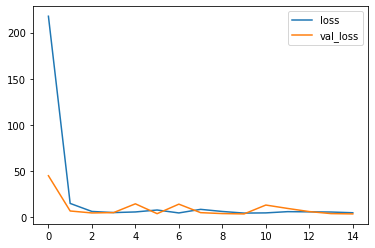

In [10]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["loss","val_loss"]);